**1- KÜTÜPHANELER**

In [1]:
# kütüphaneleri tanımlama
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

pd.set_option("display.max_columns", None)

**2- FEATURE ENGINEERING**

In [2]:
def _to_numeric_price(s: pd.Series) -> pd.Series:
    # fiyatı sayıya çevir
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(float)
    return (
        s.astype(str)
         .str.replace(r"[^\d\.\-]", "", regex=True)  # sayı olmayanları temizle
         .replace("", np.nan)                         # boşları NaN yap
         .astype(float)                               # float yap
    )

def _clip_quantile(s, low=0.01, high=0.99):
    # çok büyük/küçük değerleri kırp
    lo, hi = s.quantile(low), s.quantile(high)
    return s.clip(lo, hi)  # min-max arasında tut

def feature_engineering(df: pd.DataFrame, mode: str = "model") -> pd.DataFrame:
    df = df.copy()  # orijinali bozma, kopya al

    # 1) kaldırılacak şüpheli kolonlar
    calendar_leakage = ["avg_calendar_price", "min_calendar_price", "max_calendar_price"]
    redundant_host_cols = [
        "host_name_target_encoded",
        "host_location_target_encoded",
        "host_neighbourhood_target_encoded",
    ]
    response_time_cols = [c for c in df.columns if c.startswith("host_response_time_")]

    cols_to_remove = [c for c in (calendar_leakage + redundant_host_cols + response_time_cols) if c in df.columns]
    if cols_to_remove:
        df.drop(columns=cols_to_remove, inplace=True)  # sil

    # 2) price kolonunu ayarla
    if "price" in df.columns:
        df["price"] = _to_numeric_price(df["price"])  # sayıya çevir
        if mode.lower() == "model":
            df.drop(columns=["price"], inplace=True)   # model modunda sil

    # 3) eksik değer sayısı ve oranı
    df["missing_count"] = df.isna().sum(axis=1).astype(np.int16)  
    df["missing_ratio"] = df.isna().mean(axis=1).astype(np.float32)

    # 4) yazı kolonları
    text_cols = [c for c in df.columns if ("description" in c) or ("name" in c)]
    for col in text_cols:
        txt = df[col].fillna("").astype(str)
        df[col + "_word_count"] = txt.str.split().str.len().astype(np.int32)  # kelime say
        df[col + "_char_len"] = txt.str.len().astype(np.int32)               # karakter say

    # 5) sayısal kolonları düzelt
    num_candidates = ["bedrooms", "bathrooms", "accommodates", "number_of_reviews"]
    for c in num_candidates:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")  # sayıya çevir, hata varsa NaN

    # 6) yatak/banyo oranı
    if "bedrooms" in df.columns and "bathrooms" in df.columns:
        denom = df["bathrooms"].fillna(0) + 1
        df["bed_bath_ratio"] = (df["bedrooms"] / denom).replace([np.inf, -np.inf], np.nan)

    # 7) availability kolonları
    avail_cols = [c for c in df.columns if "availability" in c]
    if avail_cols:
        for c in avail_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df["availability_mean"] = df[avail_cols].mean(axis=1).astype(np.float32)  
        df["availability_std"]  = df[avail_cols].std(axis=1).astype(np.float32)   

    # 8) EDA modunda price oranları
    if mode.lower() == "eda":
        if "accommodates" in df.columns and "price" in df.columns:
            denom = df["accommodates"].fillna(0) + 1
            df["price_per_person"] = (df["price"] / denom).replace([np.inf, -np.inf], np.nan)

        if "number_of_reviews" in df.columns and "price" in df.columns:
            denom = df["price"].fillna(0) + 1
            df["reviews_per_price"] = (df["number_of_reviews"] / denom).replace([np.inf, -np.inf], np.nan)

    # 9) bool kolonları 0/1 yap
    bool_cols = df.select_dtypes(include="bool").columns
    for col in bool_cols:
        df[col] = df[col].astype(np.int8)

    return df  # hazır df'yi geri ver


**3- DATA LOAD**

In [3]:
# VERİ YOLLARI
train_path = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\train_unscaled.csv"  # eğitim verisi
val_path   = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\val_unscaled.csv"    # doğrulama verisi
test_path  = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\test_unscaled.csv"  # test verisi

# CSV'leri oku
train = pd.read_csv(train_path)  # eğitim verisini yükle
val   = pd.read_csv(val_path)    # doğrulama verisini yükle
test  = pd.read_csv(test_path)   # test verisini yükle

target_col = "price"  # tahmin edeceğimiz kolon


**4- FEATURE ENGINEERING**

In [4]:
# TARGET HAZIRLAMA 
y_train_raw = _to_numeric_price(train[target_col]) if target_col in train.columns else None  # price kolonunu sayıya çevir
y_val_raw   = _to_numeric_price(val[target_col])   if target_col in val.columns else None
y_test_raw  = _to_numeric_price(test[target_col])  if target_col in test.columns else None

# log hedef (uç değerleri azaltmak için)
y_train = np.log1p(y_train_raw)  # train target log1p
y_val   = np.log1p(y_val_raw)    # val target log1p
y_test  = np.log1p(y_test_raw)   # test target log1p

# X HAZIRLAMA + FEATURE ENGINEERING
X_train = train.drop(columns=[target_col], errors="ignore")  # target'ı çıkar
X_val   = val.drop(columns=[target_col], errors="ignore")
X_test  = test.drop(columns=[target_col], errors="ignore")

X_train = feature_engineering(X_train, mode="model")  # feature engineering uygula
X_val   = feature_engineering(X_val,   mode="model")
X_test  = feature_engineering(X_test,  mode="model")

print("Shapes after FE:", X_train.shape, X_val.shape, X_test.shape)  # şekilleri yazdır
print("Target shapes:", y_train.shape, y_val.shape, y_test.shape)

# BASELINE 
baseline_log = np.full_like(y_val, y_train.mean(), dtype=float)  # val için train ortalamasını tahmin et
baseline_r2  = r2_score(y_val, baseline_log)  # R² hesapla
print(f"\nBASELINE (predict mean of train in log-space) -> Val R²: {baseline_r2:.4f}")

# DEĞERLENDİRME (LOG-TRAIN, ORİJİNAL ÖLÇEKTE METRİK)
def _metrics_on_original_scale(y_log_true, y_log_pred):
    # log1p değerleri eski hâline getir
    y_true = np.expm1(y_log_true)  # orijinal price
    y_pred = np.expm1(y_log_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE hesapla
    mae  = mean_absolute_error(y_true, y_pred)          # MAE hesapla
    r2   = r2_score(y_true, y_pred)                     # R² hesapla
    return rmse, mae, r2

def evaluate(model, X_train, y_train, X_val=None, y_val=None, title="MODEL"):
    print(f"\n=== {title} RESULTS (trained on log1p(price)) ===")

    # ---------- TRAIN ----------
    pred_train_log = model.predict(X_train)  # train tahminleri
    rmse_train, mae_train, r2_train = _metrics_on_original_scale(y_train, pred_train_log)

    print("\n--- TRAIN (original price scale) ---")
    print(f"RMSE: {rmse_train:.2f}")  # hata yazdır
    print(f"MAE : {mae_train:.2f}")
    print(f"R²  : {r2_train:.4f}")

    if X_val is None or y_val is None:
        return {"train": (rmse_train, mae_train, r2_train)}

    # ---------- VAL ----------
    pred_val_log = model.predict(X_val)  # val tahminleri
    rmse_val, mae_val, r2_val = _metrics_on_original_scale(y_val, pred_val_log)

    print("\n--- VAL (original price scale) ---")
    print(f"RMSE: {rmse_val:.2f}")  # hata yazdır
    print(f"MAE : {mae_val:.2f}")
    print(f"R²  : {r2_val:.4f}")

    return {"train": (rmse_train, mae_train, r2_train),
            "val":   (rmse_val,  mae_val,  r2_val)}

def assess_silent(model, X, y_log):
    # sessizce RMSE, MAE, R² döndür
    pred_log = model.predict(X)
    return _metrics_on_original_scale(y_log, pred_log)


Shapes after FE: (12016, 105) (4006, 105) (4006, 105)
Target shapes: (12016,) (4006,) (4006,)

BASELINE (predict mean of train in log-space) -> Val R²: -0.0001


**5- DATA VISUALIZATION**


EDA DF: (12016, 108)


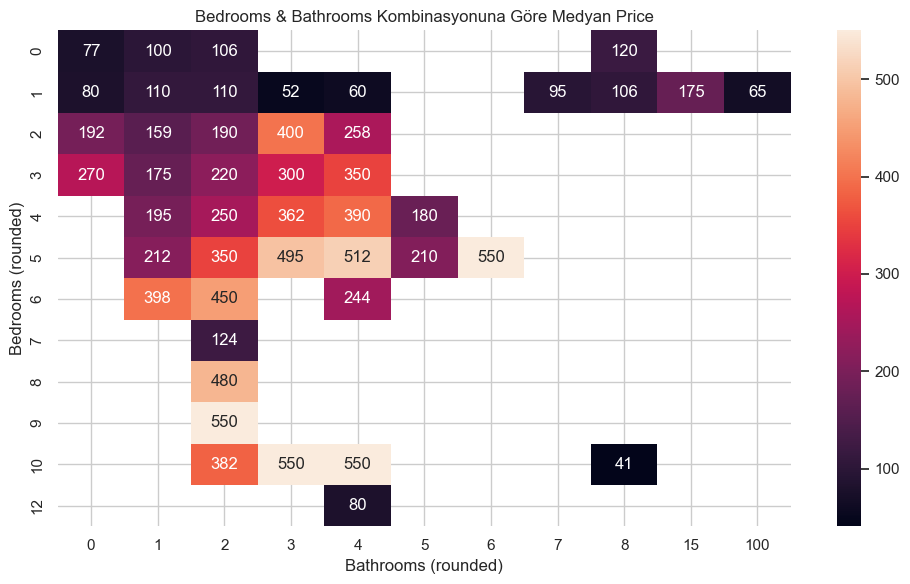

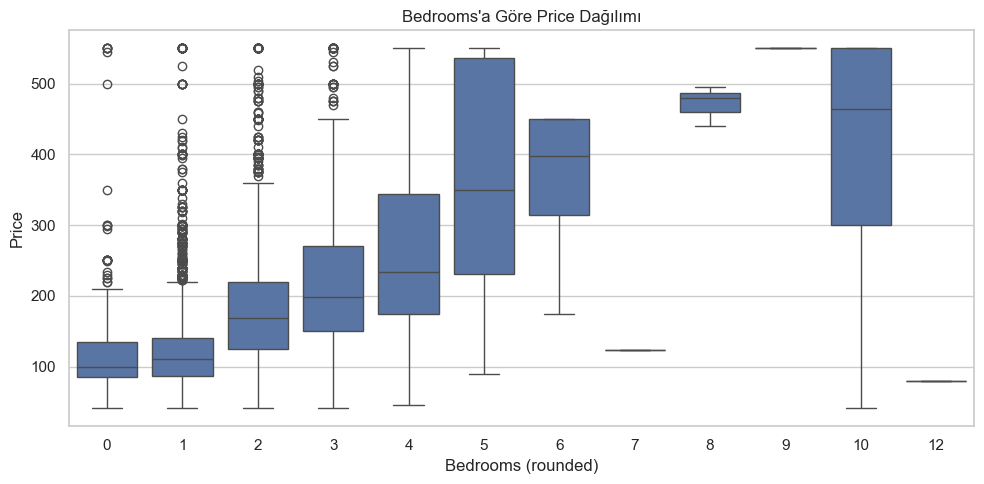

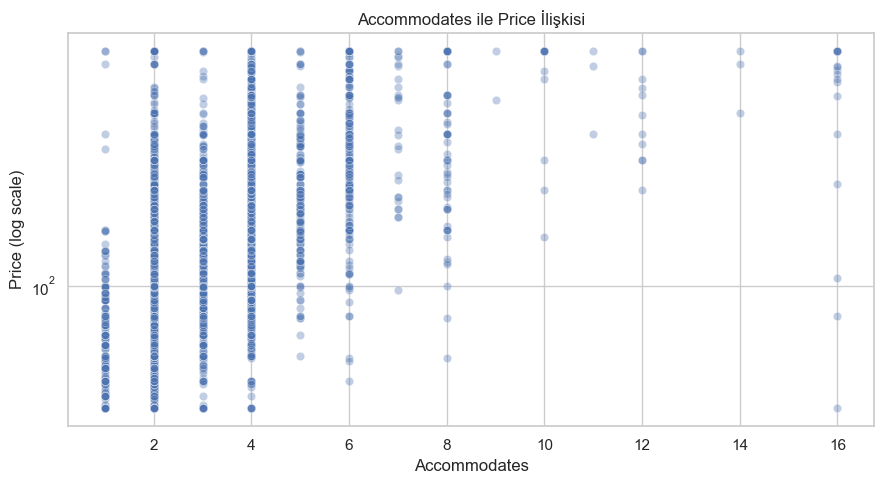

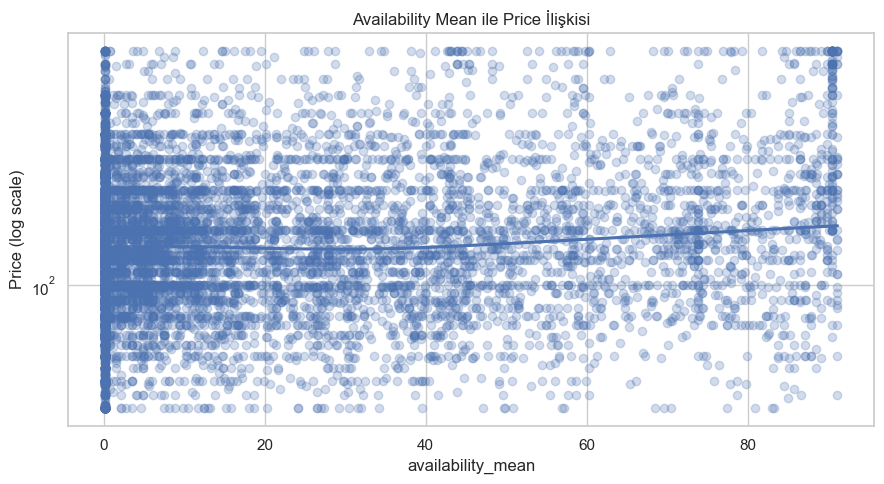

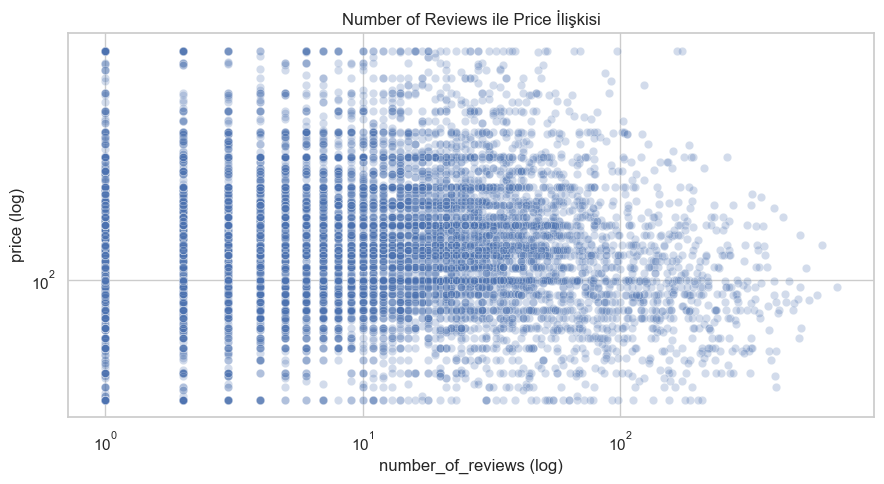

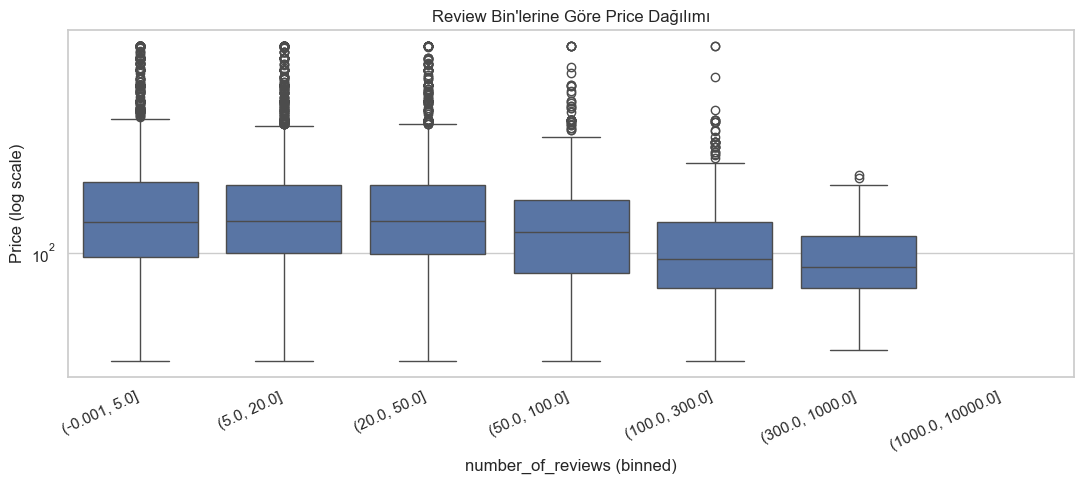

In [7]:
# EDA (veriyi gözlemleme, inceleme)

def plot_bed_bath_price_heatmap(df):
    d = df.copy()  
    d["price"] = pd.to_numeric(d["price"], errors="coerce")  # price'ı sayıya çevir
    d["bedrooms"] = pd.to_numeric(d.get("bedrooms"), errors="coerce")  # bedrooms sayıya çevir
    d["bathrooms"] = pd.to_numeric(d.get("bathrooms"), errors="coerce")  # bathrooms sayıya çevir
    d = d[["bedrooms", "bathrooms", "price"]].dropna()  # boşları at

    d["price"] = _clip_quantile(d["price"])  # uç değerleri kırp
    d["bedrooms_i"] = d["bedrooms"].round().astype(int)  # tam sayı yap
    d["bathrooms_i"] = d["bathrooms"].round().astype(int)

    pivot = d.pivot_table(index="bedrooms_i", columns="bathrooms_i", values="price", aggfunc="median")  # tablo hazırla

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f")  # ısı haritası çiz
    plt.title("Bedrooms & Bathrooms Kombinasyonuna Göre Medyan Price")
    plt.xlabel("Bathrooms (rounded)")
    plt.ylabel("Bedrooms (rounded)")
    plt.tight_layout()
    plt.show()

def plot_bedrooms_price_box(df):
    d = df.copy()
    d["price"] = pd.to_numeric(d["price"], errors="coerce")  # price sayı olsun
    d["bedrooms"] = pd.to_numeric(d.get("bedrooms"), errors="coerce")  # bedrooms sayı
    d = d[["bedrooms", "price"]].dropna()  # eksikleri çıkar

    d["price"] = _clip_quantile(d["price"])  # uç değer kırp
    d["bedrooms_i"] = d["bedrooms"].round().astype(int)  # tam sayı

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=d, x="bedrooms_i", y="price")  # boxplot çiz
    plt.title("Bedrooms'a Göre Price Dağılımı")
    plt.xlabel("Bedrooms (rounded)")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

def plot_accommodates_price_scatter(df):
    d = df.copy()
    d["price"] = pd.to_numeric(d["price"], errors="coerce")  # price sayı
    d["accommodates"] = pd.to_numeric(d.get("accommodates"), errors="coerce")  # accommodates sayı
    d = d[["accommodates", "price"]].dropna()  # eksikleri çıkar

    d["price"] = _clip_quantile(d["price"])  # uç değer kırp

    plt.figure(figsize=(9, 5))
    sns.scatterplot(data=d, x="accommodates", y="price", alpha=0.35)  # scatter plot
    plt.yscale("log")  # log ölçek
    plt.title("Accommodates ile Price İlişkisi")
    plt.xlabel("Accommodates")
    plt.ylabel("Price (log scale)")
    plt.tight_layout()
    plt.show()

def plot_availability_mean_price(df):
    d = df.copy()
    d["price"] = pd.to_numeric(d["price"], errors="coerce")  # price sayı
    d["availability_mean"] = pd.to_numeric(d.get("availability_mean"), errors="coerce")  # availability sayı
    d = d[["availability_mean", "price"]].dropna()  # boşları çıkar

    d["price"] = _clip_quantile(d["price"])  # uç değer kırp

    plt.figure(figsize=(9, 5))
    sns.regplot(data=d, x="availability_mean", y="price", scatter_kws={"alpha":0.25}, lowess=True)  # trend çiz
    plt.yscale("log")
    plt.title("Availability Mean ile Price İlişkisi")
    plt.xlabel("availability_mean")
    plt.ylabel("Price (log scale)")
    plt.tight_layout()
    plt.show()

def plot_reviews_price_loglog(df):
    d = df.copy()
    d["price"] = pd.to_numeric(d["price"], errors="coerce")  # price sayı
    d["number_of_reviews"] = pd.to_numeric(d.get("number_of_reviews"), errors="coerce")  # reviews sayı
    d = d[["number_of_reviews", "price"]].dropna()  # eksikleri çıkar

    d["price"] = _clip_quantile(d["price"])  # uç değer kırp
    d = d[(d["number_of_reviews"] >= 0) & (d["price"] > 0)]  # negatifleri çıkar

    plt.figure(figsize=(9, 5))
    sns.scatterplot(data=d, x="number_of_reviews", y="price", alpha=0.25)  # scatter
    plt.xscale("log")
    plt.yscale("log")  # log-log plot
    plt.title("Number of Reviews ile Price İlişkisi")
    plt.xlabel("number_of_reviews (log)")
    plt.ylabel("price (log)")
    plt.tight_layout()
    plt.show()

def plot_reviews_bins_price_box(df, bins=(0, 5, 20, 50, 100, 300, 1000, 10_000)):
    d = df.copy()
    d["price"] = pd.to_numeric(d["price"], errors="coerce")  # price sayı
    d["number_of_reviews"] = pd.to_numeric(d.get("number_of_reviews"), errors="coerce")  # reviews sayı
    d = d[["number_of_reviews", "price"]].dropna()  # eksikleri çıkar

    d["price"] = _clip_quantile(d["price"])  # uç değer kırp
    d["review_bin"] = pd.cut(d["number_of_reviews"], bins=bins, include_lowest=True)  # bin'le

    plt.figure(figsize=(11, 5))
    sns.boxplot(data=d, x="review_bin", y="price")  # boxplot çiz
    plt.yscale("log")
    plt.title("Review Bin'lerine Göre Price Dağılımı")
    plt.xlabel("number_of_reviews (binned)")
    plt.ylabel("Price (log scale)")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

# feature engineering 
df_eda = feature_engineering(train, mode="eda")  # train df'sini hazırla
print("\nEDA DF:", df_eda.shape)  # boyutu yazdır

# grafikleri çiz
plot_bed_bath_price_heatmap(df_eda)  # bedrooms-bathrooms vs price
plot_bedrooms_price_box(df_eda)      # bedrooms vs price boxplot
plot_accommodates_price_scatter(df_eda)  # accommodates vs price scatter
plot_availability_mean_price(df_eda)     # availability mean vs price
plot_reviews_price_loglog(df_eda)        # reviews vs price log-log
plot_reviews_bins_price_box(df_eda)      # reviews bin vs price boxplot


**6- MODEL 1: ExtraTrees**

In [8]:
# 1) TREE-ONLY: ExtraTrees (SCALER/PCA YOK)

# Hiperparametreler
ET_PARAMS = {
    "n_estimators": 800,    
    "max_depth": None,      
    "min_samples_split": 2, 
    "min_samples_leaf": 2,  
    "random_state": 42,     
    "n_jobs": -1            
}

# modeli oluştur
et = ExtraTreesRegressor(
    n_estimators=ET_PARAMS["n_estimators"],
    max_depth=ET_PARAMS["max_depth"],
    min_samples_split=ET_PARAMS["min_samples_split"],
    min_samples_leaf=ET_PARAMS["min_samples_leaf"],
    random_state=ET_PARAMS["random_state"],
    n_jobs=ET_PARAMS["n_jobs"]
)

et.fit(X_train, y_train)  # modeli eğit
evaluate(et, X_train, y_train, X_val, y_val, "EXTRATREES (tree-only)")  # train + val sonuç

# kaydet ve tekrar yükle
model_path = "extra_trees_model.pkl"
joblib.dump(et, model_path)
et_loaded = joblib.load(model_path)

evaluate(et_loaded, X_test, y_test, None, None, "EXTRATREES TEST (tree-only)")  # test seti



=== EXTRATREES (tree-only) RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 98.11
MAE : 6.64
R²  : 0.6046

--- VAL (original price scale) ---
RMSE: 136.55
MAE : 37.10
R²  : 0.2092

=== EXTRATREES TEST (tree-only) RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 68.72
MAE : 36.63
R²  : 0.5131


{'train': (68.72406983868692, 36.62741156710159, 0.513125550040713)}

**7- MODEL 2-3: SVR + KNN**

In [13]:
# veriyi ölçekle
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # train fit et ve scale et
X_val_scaled   = scaler.transform(X_val)        # val scale et
X_test_scaled  = scaler.transform(X_test)       # test scale et

# PCA ile boyut düşür
pca = PCA(n_components=0.95, random_state=42)  
X_train_pca = pca.fit_transform(X_train_scaled) # train fit et + PCA uygula
X_val_pca   = pca.transform(X_val_scaled)      # val PCA uygula
X_test_pca  = pca.transform(X_test_scaled)     # test PCA uygula

print("\nPCA components:", X_train_pca.shape[1])  # kaç PCA component var

# SVR modeli hiperparametreleri
SVR_PARAMS = {
    "kernel": "rbf",   # RBF kernel
    "C": 30,           # regularizasyon
    "gamma": 0.05,     # kernel genişliği
    "epsilon": 0.05    # tolerans
}

# SVR modeli oluştur
svr = SVR(
    kernel=SVR_PARAMS["kernel"],
    C=SVR_PARAMS["C"],
    gamma=SVR_PARAMS["gamma"],
    epsilon=SVR_PARAMS["epsilon"]
)

svr.fit(X_train_pca, y_train)  # modeli train et
evaluate(svr, X_train_pca, y_train, X_val_pca, y_val, "SVR (scaled + PCA)")  # train+val
evaluate(svr, X_test_pca,  y_test, None, None, "SVR TEST (scaled + PCA)")  # test

# KNN modeli hiperparametreleri
KNN_PARAMS = {
    "n_neighbors": 15,  # komşu sayısı
    "weights": "distance",  # yakınlığa göre ağırlık
    "p": 2               # Euclidean mesafe
}

# KNN modeli oluştur
knn = KNeighborsRegressor(
    n_neighbors=KNN_PARAMS["n_neighbors"],
    weights=KNN_PARAMS["weights"],
    p=KNN_PARAMS["p"]
)

knn.fit(X_train_pca, y_train)  # modeli train et
evaluate(knn, X_train_pca, y_train, X_val_pca, y_val, "KNN (scaled + PCA)")  # train+val
evaluate(knn, X_test_pca,  y_test, None, None, "KNN TEST (scaled + PCA)")  # test



PCA components: 53

=== SVR (scaled + PCA) RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 10.59
MAE : 7.24
R²  : 0.9954

--- VAL (original price scale) ---
RMSE: 145.74
MAE : 44.85
R²  : 0.0992

=== SVR TEST (scaled + PCA) RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 82.95
MAE : 43.98
R²  : 0.2907

=== KNN (scaled + PCA) RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 0.00
MAE : 0.00
R²  : 1.0000

--- VAL (original price scale) ---
RMSE: 142.49
MAE : 44.58
R²  : 0.1389

=== KNN TEST (scaled + PCA) RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 80.59
MAE : 43.78
R²  : 0.3304


{'train': (80.59367035196692, 43.77535851165292, 0.3304220974363222)}

**8- MODEL 4: AdaBoost**

In [12]:
# AdaBoost modeli hiperparametreleri
ADA_PARAMS = {
    "n_estimators": 800,      # kaç ağaç
    "learning_rate": 0.03,    # öğrenme hızı
    "random_state": 42         # sonuç sabit
}

# AdaBoost modeli oluştur
ada = AdaBoostRegressor(
    n_estimators=ADA_PARAMS["n_estimators"],
    learning_rate=ADA_PARAMS["learning_rate"],
    random_state=ADA_PARAMS["random_state"]
)

ada.fit(X_train, y_train)  # modeli train et
evaluate(ada, X_train, y_train, X_val, y_val, "ADABOOST")  # train+val performans
evaluate(ada, X_test,  y_test, None, None, "ADABOOST TEST")  # test performans



=== ADABOOST RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 124.76
MAE : 48.91
R²  : 0.3607

--- VAL (original price scale) ---
RMSE: 141.41
MAE : 47.78
R²  : 0.1519

=== ADABOOST TEST RESULTS (trained on log1p(price)) ===

--- TRAIN (original price scale) ---
RMSE: 80.27
MAE : 46.50
R²  : 0.3358


{'train': (80.26637059550312, 46.49894908705755, 0.33584951330940427)}

**9- MODEL 5: CatBoost**

In [10]:
# CatBoost (SCALER/PCA YOK)
# kategorik kolonları bul
cat_feature_cols = [c for c in X_train.columns if str(X_train[c].dtype) in ("object", "category")]
cat_features = [X_train.columns.get_loc(c) for c in cat_feature_cols]  

# CatBoost hiperparametreleri
CAT_PARAMS = {
    "iterations": 3000,       # kaç tur ağaç
    "learning_rate": 0.03,    # öğrenme hızı
    "depth": 8,               # ağaç derinliği
    "loss_function": "RMSE",  # hata ölçüsü
    "random_seed": 42,         # sabit sonuç
    "verbose": 200             # kaç iterasyon sonra yazdır
}

# modeli oluştur
cat = CatBoostRegressor(
    iterations=CAT_PARAMS["iterations"],
    learning_rate=CAT_PARAMS["learning_rate"],
    depth=CAT_PARAMS["depth"],
    loss_function=CAT_PARAMS["loss_function"],
    random_seed=CAT_PARAMS["random_seed"],
    verbose=CAT_PARAMS["verbose"]
)

# modeli eğit
cat.fit(
    X_train, y_train,
    cat_features=cat_features if len(cat_features) > 0 else None, 
    eval_set=(X_val, y_val)  
)

# performans kontrolü
evaluate(cat, X_train, y_train, X_val, y_val, "CATBOOST (no scale/no PCA)")  # train+val
evaluate(cat, X_test,  y_test, None, None, "CATBOOST TEST (no scale/no PCA)")  # test


0:	learn: 0.4973991	test: 0.4882577	best: 0.4882577 (0)	total: 181ms	remaining: 9m 3s
200:	learn: 0.2964033	test: 0.3083862	best: 0.3083862 (200)	total: 5.24s	remaining: 1m 12s
400:	learn: 0.2726195	test: 0.2984749	best: 0.2984749 (400)	total: 9.78s	remaining: 1m 3s
600:	learn: 0.2506217	test: 0.2936879	best: 0.2936879 (600)	total: 13.8s	remaining: 55.1s
800:	learn: 0.2333564	test: 0.2913042	best: 0.2912966 (797)	total: 17.9s	remaining: 49.1s
1000:	learn: 0.2178945	test: 0.2903113	best: 0.2903113 (1000)	total: 22.5s	remaining: 45s
1200:	learn: 0.2037957	test: 0.2895536	best: 0.2895448 (1197)	total: 27.3s	remaining: 40.8s
1400:	learn: 0.1908504	test: 0.2888444	best: 0.2888444 (1400)	total: 31.3s	remaining: 35.7s
1600:	learn: 0.1793435	test: 0.2885459	best: 0.2884918 (1578)	total: 35.8s	remaining: 31.3s
1800:	learn: 0.1683936	test: 0.2883207	best: 0.2882864 (1787)	total: 40.6s	remaining: 27s
2000:	learn: 0.1592145	test: 0.2881105	best: 0.2880876 (1977)	total: 45.2s	remaining: 22.6s
2200:

{'train': (63.7872897939324, 33.88726582937674, 0.5805622222999545)}

**10- SUMMARY TABLE**

In [14]:
# Modellerin validation sonuçlarını karşılaştır
summary_val = pd.DataFrame({
    "Model": ["CatBoost", "ExtraTrees", "SVR", "KNN", "AdaBoost"],

    "Val_RMSE": [  # val seti için RMSE hesapla
        assess_silent(cat, X_val,     y_val)[0],
        assess_silent(et,  X_val,     y_val)[0],
        assess_silent(svr, X_val_pca, y_val)[0],
        assess_silent(knn, X_val_pca, y_val)[0],
        assess_silent(ada, X_val,     y_val)[0],
    ],

    "Val_MAE": [   # val seti için MAE hesapla
        assess_silent(cat, X_val,     y_val)[1],
        assess_silent(et,  X_val,     y_val)[1],
        assess_silent(svr, X_val_pca, y_val)[1],
        assess_silent(knn, X_val_pca, y_val)[1],
        assess_silent(ada, X_val,     y_val)[1],
    ],

    "Val_R2": [    # val seti için R² hesapla
        assess_silent(cat, X_val,     y_val)[2],
        assess_silent(et,  X_val,     y_val)[2],
        assess_silent(svr, X_val_pca, y_val)[2],
        assess_silent(knn, X_val_pca, y_val)[2],
        assess_silent(ada, X_val,     y_val)[2],
    ]
})

# R² değerine göre sırala (en iyi model başta)
summary_val = summary_val.sort_values("Val_R2", ascending=False).reset_index(drop=True)
print(summary_val)  # tabloyu yazdır


        Model    Val_RMSE    Val_MAE    Val_R2
0    CatBoost  135.005050  34.269039  0.226990
1  ExtraTrees  136.551660  37.099482  0.209178
2    AdaBoost  141.407804  47.779752  0.151930
3         KNN  142.488630  44.580974  0.138916
4         SVR  145.741441  44.853561  0.099153


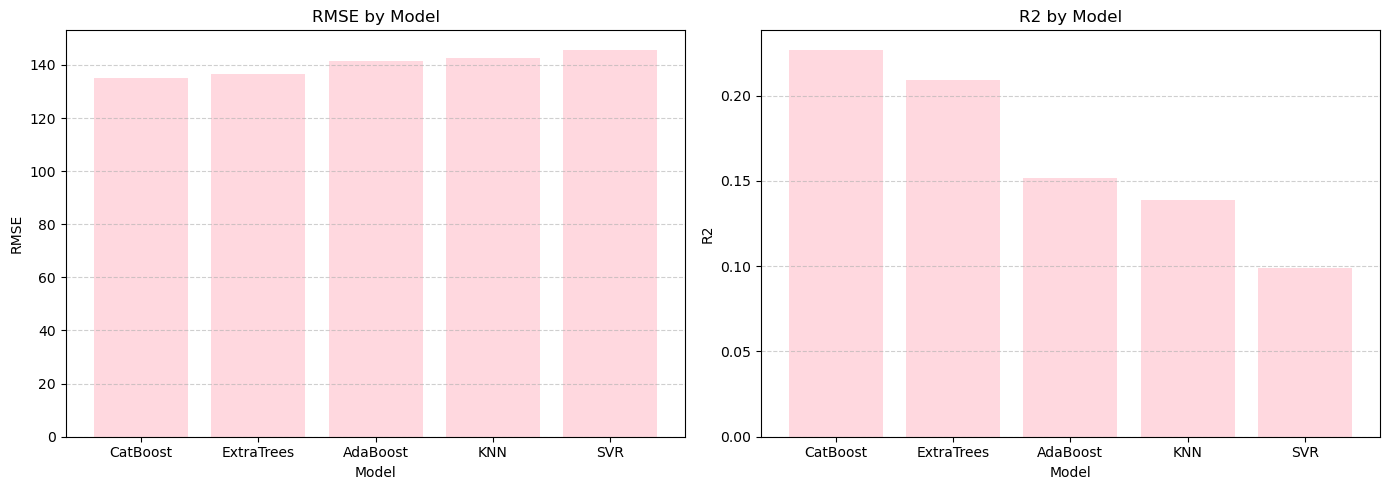

In [2]:
# Modellerin Test Set MAE ve Test Set R² Karşılaştırması 
import matplotlib.pyplot as plt

models = [
    "CatBoost",
    "ExtraTrees",
    "AdaBoost",
    "KNN",
    "SVR"
]

rmse = [
    135.005050,
    136.551660,
    141.407804,
    142.488630,
    145.741441
]

r2 = [
    0.226990,
    0.209178,
    0.151930,
    0.138916,
    0.099153
]

color = "#FFD8DF"

plt.figure(figsize=(14, 5))

# RMSE
plt.subplot(1, 2, 1)
plt.bar(models, rmse, color=color)
plt.title("RMSE by Model")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# R2
plt.subplot(1, 2, 2)
plt.bar(models, r2, color=color)
plt.title("R2 by Model")
plt.xlabel("Model")
plt.ylabel("R2")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
